In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime
import seaborn as sns

In [3]:
# import df:
df = pd.read_csv('./Datasets/cleaned_df.csv')
df.head()

,date,state_name,county_name,county_code,aqi,category,defining_parameter,defining_site,number_of_sites_reporting
0,2013-01-01,California,Alameda,1,62,Moderate,PM2.5,06-001-0007,4
1,2013-01-02,California,Alameda,1,61,Moderate,PM2.5,06-001-0007,4
2,2013-01-03,California,Alameda,1,81,Moderate,PM2.5,06-001-0007,4
3,2013-01-04,California,Alameda,1,78,Moderate,PM2.5,06-001-0007,4
4,2013-01-05,California,Alameda,1,84,Moderate,PM2.5,06-001-0007,4


In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
df = df.set_index('date')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 218538 entries, 2013-01-01 to 2009-12-31
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   state_name                 218538 non-null  object
 1   county_name                218538 non-null  object
 2   county_code                218538 non-null  int64 
 3   aqi                        218538 non-null  int64 
 4   category                   218538 non-null  object
 5   defining_parameter         218538 non-null  object
 6   defining_site              218538 non-null  object
 7   number_of_sites_reporting  218538 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 15.0+ MB


In [7]:
from statsmodels.tsa.stattools import adfuller

# adfuller(df['aqi'])[0:2]

In [8]:
for i in df.county_name.unique().tolist():
    mask = df[df['county_name'] == i]
    print(f" ADFuller scores for {i} is {adfuller(mask['aqi'])[0:2]}")

 ADFuller scores for Alameda is (-19.998393488258447, 0.0)
 ADFuller scores for Alpine is (-3.2326206351998152, 0.01817243143473612)
 ADFuller scores for Amador is (-4.374251810568105, 0.0003295751082804015)
 ADFuller scores for Butte is (-8.763214252713718, 2.6396965832190476e-14)
 ADFuller scores for Calaveras is (-5.673928907257773, 8.792945631045284e-07)
 ADFuller scores for Colusa is (-8.647658598002913, 5.2176015402288046e-14)
 ADFuller scores for Contra Costa is (-17.311319639786785, 5.552131411197455e-30)
 ADFuller scores for Del Norte is (-5.601897477567881, 1.2592555307787583e-06)
 ADFuller scores for El Dorado is (-4.5020173487931165, 0.00019499601616468942)
 ADFuller scores for Fresno is (-8.052208336816744, 1.7299163802619825e-12)
 ADFuller scores for Glenn is (-9.937582285881366, 2.7177429017752166e-17)
 ADFuller scores for Humboldt is (-6.711603959539166, 3.6687304350627987e-09)
 ADFuller scores for Imperial is (-6.991790149119383, 7.711303601909724e-10)
 ADFuller scores

In [9]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferr

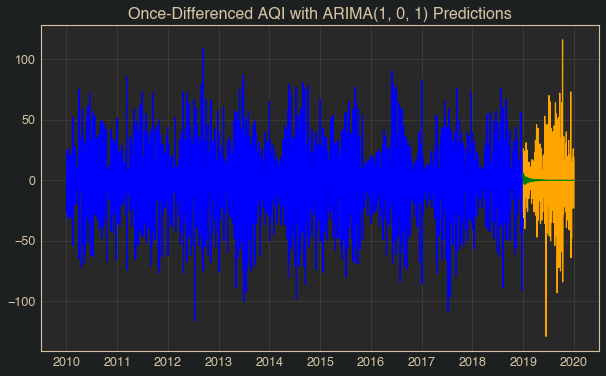

In [10]:
la = df[df['county_name'] == 'Los Angeles'].sort_index()

y_train = la['aqi']['2010-01-01':'2018-12-31'] # dataset to train
y_test = la['aqi']['2019-01-01':'2019-12-31'] # last X months for test  
# predict_date = len(y) - len(y['2019-01-01':'2019-12-31']) # the number of data points for the test set

# split data:
# y_train, y_test = train_test_split(la['aqi'], test_size=1/132, shuffle=False)

# instatiate ARIMA
model = ARIMA(endog=y_train, order=(6,1,9)) 

# fit ARIMA model
arima = model.fit()

#generate predictions
preds = model.predict(params = arima.params, start=y_test.index[0], end=y_test.index[-1])

# Plot data.
plt.figure(figsize=(10,6))
# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train).diff(), color = 'blue')
# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test).diff(), color = 'orange')
# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')
plt.title(label = 'Once-Differenced AQI with ARIMA(6, 1, 9) Predictions', fontsize=16)
plt.show();

In [14]:
from sklearn import metrics
# generate predictions off the model
pred = arima.predict(dynamic=True, start=y_test.index[0], end=y_test.index[-1])

    # calculate RMSE and show the score 
rmse = metrics.mean_squared_error(y_test, pred, squared=False)
rmse

89.80665316858328

In [15]:
def rmse_ma(true_val, pred, n):
    return (sum((true_val[:n] - pred[:n]) ** 2)/n)**(1/2)

In [16]:
rmse_ma(y_test, pred, 7)

70.6616853746476

### SARIMA

In [17]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in pdq]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [18]:
sarima_grid_search(y,365)

NameError: name 'y' is not defined